In [3]:
import os
import glob
import rawpy
import exifread
import cv2 as cv
import numpy as np

In [4]:
refIndex = 0
rawBayers = []
burstPath = "/home/lianghao/Documents/Learning/ISP/Image/IPOL_hdrplus_gopro_raw_bursts/hand_iso1600/"
alignmen_params = {
				'mode': 'bayer',  # images are single image Bayer / Color Filter Arrays
				'tuning': {
					# WARNING: these parameters are defined fine-to-coarse!
					'factors': [1, 2, 4, 4],
					'tileSizes': [16, 16, 16, 8],
					'searchRadia': [1, 4, 4, 4],
					'distances': ['L1', 'L2', 'L2', 'L2'],
					'subpixels': [False, True, True, True]  # if you want to compute subpixel tile alignment at each pyramid level
				},
				# rawpy parameters for images with motion fields
				'rawpyArgs': {
					'demosaic_algorithm' : rawpy.DemosaicAlgorithm.AHD,  # used in HDR+ supplement
					'half_size' : False,
					'use_camera_wb' : True,
					'use_auto_wb' : False,
					'no_auto_bright': True,
					'output_color' : rawpy.ColorSpace.sRGB,  # sRGB
					'output_bps' : 8
				},
				'writeMotionFields': False,
				'writeAlignedTiles': False
			}

rawPathList = glob.glob(os.path.join(burstPath, "*.dng"))
rawPathList.sort()
for rawPath in rawPathList:
    with rawpy.imread(rawPath) as rawObject:
        rawBayers.append(rawObject.raw_image.copy())

In [5]:
with rawpy.imread(rawPathList[refIndex]) as refRawpy:
    blackLevel = refRawpy.black_level_per_channel.copy()
    whiteLevel = refRawpy.white_level

In [6]:
h, w = rawBayers[refIndex].shape
if alignmen_params["mode"] == "bayer":
    tileSize = 2 * alignmen_params['tuning']['tileSizes'][0]
else:
    tileSize = alignmen_params['tuning']['tileSizes'][0]

In [7]:
# padding setting 
padding_height = (tileSize - h % tileSize) % tileSize
padding_width = (tileSize - w % tileSize) % tileSize
padding_overlap_height, padding_overlap_width = tileSize // 2, tileSize // 2
padding_top = padding_overlap_height
padding_bottom = padding_overlap_height + padding_height
padding_left = padding_overlap_width
padding_right = padding_overlap_width + padding_left

images_padding = []
for i in range(len(rawBayers)):
    im = np.pad(rawBayers[i], ((padding_top, padding_bottom), (padding_left, padding_right)), mode="symmetric")
    images_padding.append(im)

reference = images_padding[refIndex]
alternative = images_padding.pop(refIndex)

mplements the coarse-to-fine alignment on 4-level gaussian pyramids as defined in Algorithm 1 of Section 3 of the IPOL article.

In [8]:
def getTiles(a, window, steps=None, axis=None):
	ashp = np.array(a.shape)

	if axis is not None:
		axs = np.array(axis, ndmin=1)
		assert np.all(np.in1d(axs, np.arange(ashp.size))), "Axes out of range"
	else:
		axs = np.arange(ashp.size)

	window = np.array(window, ndmin=1)
	assert (window.size == axs.size) | (window.size == 1), "Window dims and axes don't match"
	wshp = ashp.copy()
	wshp[axs] = window
	assert np.all(wshp <= ashp), "Window is bigger than input array in axes"

	stp = np.ones_like(ashp)
	if steps:
		steps = np.array(steps, ndmin=1)
		assert np.all(steps > 0), "Only positive steps allowed"
		assert (steps.size == axs.size) | (steps.size == 1), "Steps and axes don't match"
		stp[axs] = steps

	astr = np.array(a.strides)

	shape = tuple((ashp - wshp) // stp + 1) + tuple(wshp)
	strides = tuple(astr * stp) + tuple(astr)
	print(shape, strides)

	return np.squeeze(np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides))

In [12]:
refTiles = getTiles(reference, window=tileSize, steps=tileSize // 2)

(189, 252, 32, 32) (129536, 32, 8096, 2)


In [13]:
reference.shape

(3040, 4048)

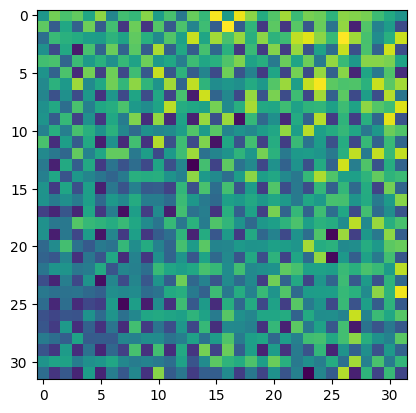

In [18]:
plt.imshow(refTiles[100][100])

In [21]:
b = np.squeeze(np.lib.stride_tricks.as_strided(reference, shape=(189, 252, 32, 32), strides=(129536, 32, 8096, 2)))

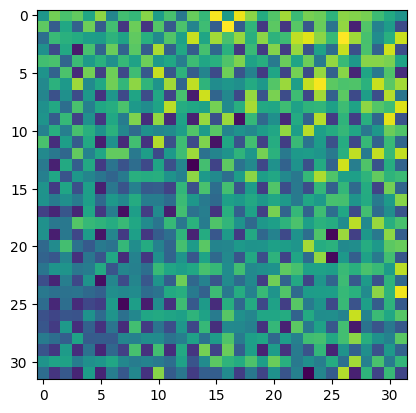

In [22]:
plt.imshow(b[100][100])